In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
sys.path.insert(1, oj(sys.path[0], '..', 'vision_fit'))  # insert parent path
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
import pandas as pd
import math
# plt.style.use('dark_background')
from mog_fit import data
from collections import OrderedDict
from sklearn import preprocessing

import torch
from torch.autograd import Variable
from mog_analyze import viz
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings("ignore")

from vision_fit import data

import viz_weights
%matplotlib inline
%load_ext autoreload
%autoreload 2

import style
cb = '#33ccff'

In [2]:
style.set_style()

# load results from a directory

In [3]:
# depending on how much is saved, this may take a while
# out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/dsets_small'
out_dir = '/scratch/users/vision/yu_dl/raaz.rsk/track_acts/dsets_small_rerun'
fnames = sorted([fname for fname in os.listdir(out_dir) ])
#                  if not 'mnist' in fname and 
#                  'numlays=4' in fname and 
#                  'batchsize=100' in fname and not 'batchsize=1000' in fname])
#                   and 
#                  'numlays=4' in fname]) # and 
#                  'batchsize=100' in fname and 
#                  not 'batchsize=1000' in fname])
# weights_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
#                 if fname.startswith('weights')]
# results_weights = pd.concat(weights_list, axis=1).T.infer_objects()

results_list = [pd.Series(pkl.load(open(oj(out_dir, fname), "rb"))) for fname in tqdm(fnames) 
                if not fname.startswith('weights') and not fname.startswith('idx')]
results = pd.concat(results_list, axis=1).T.infer_objects()

save_dir = 'results_weights'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    
# print('loaded', results_weights.shape[0], 'runs')

100%|██████████| 108/108 [00:03<00:00, 27.49it/s]


*add cols*

In [4]:
idxs = results[(results.num_points == 10)].index
for idx in idxs:
    results.iloc[idx]['accs_train'] *= 10
    results.iloc[idx]['losses_train'] *= 10    

In [5]:
from process_results import process_results
its, ts, results = process_results(results)

# plot max corrs
*note some things disappear in below plot as a result of nans*

In [ ]:
r = results
# r = results[results.seed == 0]
# r = results[results.num_layers == 4]
# print(r[['lr', 'first_layer_lr_mult', 'corr0_final']])
hue = 'num_points'

plt.figure(figsize=(10, 10))
R, C = 2, 2
rm = r[r.dset == 'mnist_small']
plt.subplot(R, C, 1)
plt.title('mnist')

sns.scatterplot(rm.max_test_acc, rm.corr0_final, hue=rm[hue], alpha=0.5)
plt.ylim(0, 1)

plt.subplot(R, C, 2)
plt.title('mnist')
sns.scatterplot(rm.max_test_acc, rm.corr1_final, hue=rm[hue])
plt.ylim(0, 1)


rm = r[r.dset == 'cifar10_small']
# rm = rm[rm.max_test_acc > 0.4]
plt.subplot(R, C, 3)
plt.title('cifar')
sns.scatterplot(rm.max_test_acc, rm.corr0_final, hue=rm[hue])
plt.ylim(0, 1)

plt.subplot(R, C, 4)
plt.title('cifar')
sns.scatterplot(rm.max_test_acc, rm.corr1_final, hue=rm[hue])
plt.ylim(0, 1)
plt.show()

# track things over time

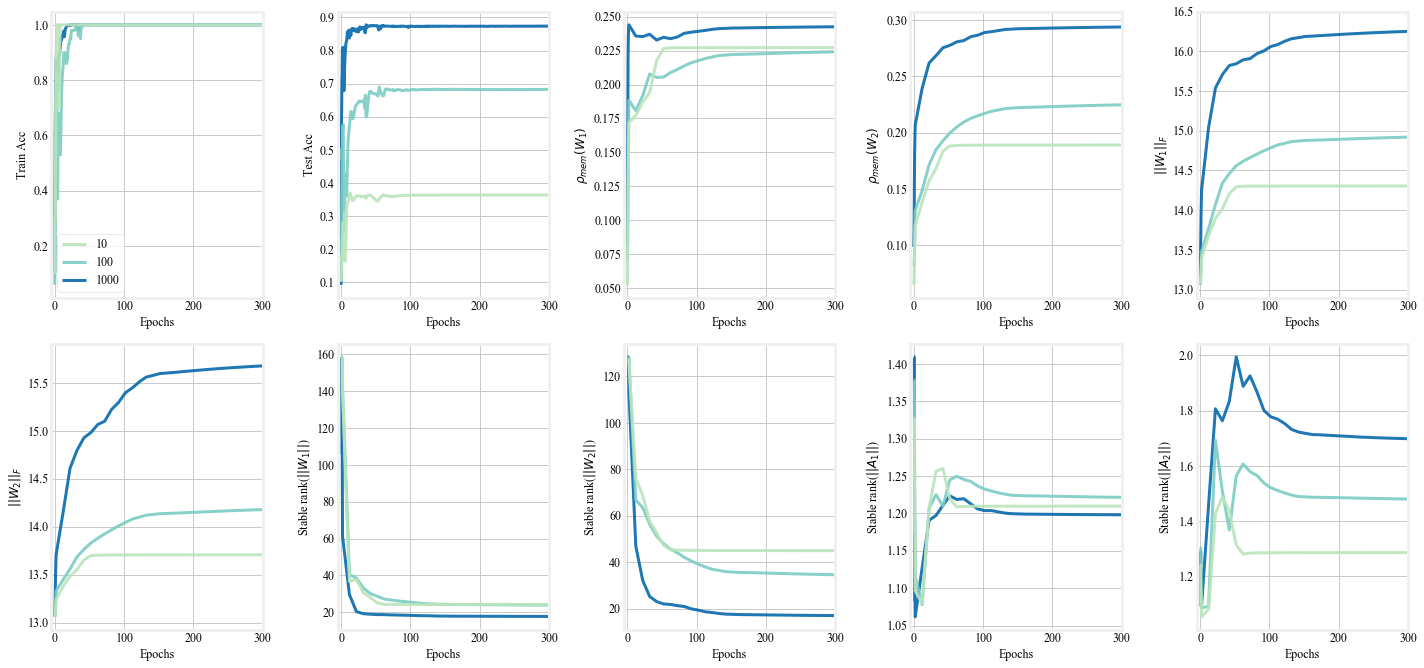

In [10]:
r = results
r = r[(r.dset == 'mnist_small') * (r.seed == 0)]
r = r[r.max_train_acc > 0.999]
r = r[r.optimizer == 'adam']
# print(r.seed)

R, C = 2, 5
plt.figure(figsize=(20, 9.5), facecolor='w')
xlim = 1000
# cs_5 = {1: '#f0f9e8', 2: '#bae4bc', 5: '#7bccc4', 10: '#43a2ca', 20: '#0868ac'}
cs_5 = {10: '#bae4bc', 100: '#7bccc4', 1000: '#0668ac'}
vals = ['accs_train', 'accs_test', 'corr0', 'corr1', 'fc0_fro', 'fc1_fro', 'fc0_stab_rank', 'fc1_stab_rank', 'act0_stab_rank', 'act1_stab_rank']
val_labs = ['Train Acc', 'Test Acc', '$\\rho_{mem}(W_1)$', '$\\rho_{mem}(W_2)$', 
        '$||W_1||_F$', '$||W_2||_F$', 'Stable rank($||W_1||$)', 'Stable rank($||W_2||$)', 'Stable rank($||A_1||$)', 'Stable rank($||A_2||$)']
hue = 'num_points'
a = 0.5
# well-behaved
for j, (_, row) in enumerate(r.iterrows()):

    for i, val in enumerate(vals):
        plt.subplot(R, C, i+1)
#         lab = row.optimizer.upper() + ', ' + str(row[hue])
        lab = str(row[hue])        
        try:
            if row.optimizer == 'adam':
                plt.plot(ts, row[val], color=cs_5[row[hue]], label=lab, alpha=0.9)
            else:
                plt.plot(ts, row[val], '--', color=cs_5[row[hue]], label=lab, alpha=0.9)
        except:
            if row.optimizer == 'adam':            
                plt.plot(row.its[:row[val].size], row[val], color=cs_5[row[hue]], label=lab, alpha=0.9)
            else:
                plt.plot(row.its[:row[val].size], row[val], '--', color=cs_5[row[hue]], label=lab, alpha=0.9)
        plt.xlabel('Epochs')
        plt.ylabel(val_labs[i])
        plt.xlim((-5, 300))

plt.subplot(R, C, 1)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
# keys = ['SGD, 10', 'ADAM, 10', 'SGD, 100', 'ADAM, 100', 'SGD, 100', 'ADAM, 1000']
keys = ['10', '100', '1000']
vs = [by_label[key] for key in keys]
plt.legend(vs, keys)
plt.tight_layout()

plt.savefig('vary_dset_size.pdf')